In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

seed = 2025

In [ ]:
# Load preprocessed data
train_df = pd.read_csv('train_preprocessed.csv')
test_df = pd.read_csv('test_preprocessed.csv')

**Two-Stage Modeling for Spending Prediction**

Stage 1: Binary Classification (Will Spend?)\
Predict whether a player will spend (spending_30d > 0)

Stage 2: Regression (How Much?)\
Predict spending amount for players who will spend (spending_30d > 0)

In [ ]:
# Separate features and target
exclude_cols = ['id', 'player_id', 'spending_30d']
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

X = train_df[feature_cols]
X_test = test_df[feature_cols]
y_original = train_df['spending_30d']

# Stage 1: Binary target (will spend or not)
y_binary = (y_original > 0).astype(int)

# Stage 2: Regression target (amount) - only for spenders
mask_spenders = y_original > 0
print(f"selected spenders data: {mask_spenders.mean()*100:.2f}%")
X_spenders = X[mask_spenders]
y_amount = y_original[mask_spenders]

selected spenders data: 51.80%


# Stage 1: Binary Classification


### Model selection

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

clf_models = {
    'Logistic Regression': LogisticRegression(random_state=seed, verbose=0),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=seed, n_jobs=-1),
    # 'ExtraTrees': ExtraTreesClassifier(n_estimators=100, random_state=seed),
    # 'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=seed),
    'XGBoost': XGBClassifier(random_state=seed, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=seed, verbose=-1, pos_class_weight='balanced'),
    'CatBoost': CatBoostClassifier(random_state=seed, verbose=0)
}

In [42]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)


In [ ]:
cv_results = {}

for name, model in tqdm(clf_models.items()):
    f1_scores = cross_val_score(
        model,
        X,
        y_binary,
        cv=kf,
        scoring='f1'
    )
    
    auc_scores = cross_val_score(
        model,
        X,
        y_binary,
        cv=kf,
        scoring='roc_auc'
    )
    
    cv_results[name] = {
        'CV_F1': f1_scores.mean(),
        'CV_F1_std': f1_scores.std(),
        'CV_AUC': auc_scores.mean(),
        'CV_AUC_std': auc_scores.std()
    }

cv_df = pd.DataFrame.from_dict(cv_results, orient='index')
cv_df = cv_df.sort_values(by='CV_AUC', ascending=False)  # เรียงตาม AUC

best_model_name = cv_df.index[0]
print(f"Best Model (by AUC-ROC): {best_model_name}")
print(f"   AUC: {cv_df.loc[best_model_name, 'CV_AUC']:.4f} ± {cv_df.loc[best_model_name, 'CV_AUC_std']:.4f}")
print(f"   F1:  {cv_df.loc[best_model_name, 'CV_F1']:.4f} ± {cv_df.loc[best_model_name, 'CV_F1_std']:.4f}")

  0%|          | 0/6 [00:00<?, ?it/s]


✅ Best Model (by AUC-ROC): LightGBM
   AUC: 0.9401 ± 0.0012
   F1:  0.8241 ± 0.0033


In [44]:
cv_df

,CV_F1,CV_F1_std,CV_AUC,CV_AUC_std
LightGBM,0.824103,0.003290,0.940125,0.001181
CatBoost,0.820261,0.003639,0.938522,0.001478
Random Forest,0.819116,0.001971,0.937503,0.001251
XGBoost,0.813252,0.003238,0.936083,0.001497
KNN,0.764883,0.003247,0.900179,0.001699
Logistic Regression,0.684519,0.002538,0.864072,0.001706


In [45]:
best_clf_name = 'LightGBM'
best_clf_model = LGBMClassifier(random_state=seed, verbose=-1)

In [46]:
# Train on full training data
best_clf_model.fit(X, y_binary)
print("\n✅ Model trained on full dataset")

# Predict probabilities for two-stage modeling
y_prob_spend = best_clf_model.predict_proba(X)[:, 1]
print(f"✅ Generated spending probabilities (mean: {y_prob_spend.mean():.4f})")


✅ Model trained on full dataset
✅ Generated spending probabilities (mean: 0.3582)


### Model Tuning (Optuna)

In [14]:
import optuna
from sklearn.model_selection import cross_val_score

def objective_clf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': seed,
        'verbose': -1
    }
    
    model = LGBMClassifier(**params)
    
    # Use AUC-ROC as the optimization metric
    auc_scores = cross_val_score(
        model, X, y_binary,
        cv=kf, scoring='roc_auc', n_jobs=-1
    )
    
    return auc_scores.mean()

# Create Optuna study
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize', study_name='lgbm_classifier')

print("Starting Optuna hyperparameter tuning for LightGBM Classifier...")
print(f"Optimizing on {len(X)} samples with {X.shape[1]} features\n")

study.optimize(objective_clf, n_trials=50, show_progress_bar=True)

print("\n" + "=" * 70)
print("OPTUNA OPTIMIZATION RESULTS - CLASSIFIER")
print("=" * 70)
print(f"\n✅ Best AUC-ROC: {study.best_value:.6f}")
print(f"\n📊 Best Parameters:")
for param, value in study.best_params.items():
    print(f"   {param}: {value}")

# Update best classifier with optimized parameters
best_clf_model = LGBMClassifier(**study.best_params, random_state=seed, verbose=-1)
print(f"\n✅ Updated best_clf_model with optimized parameters")

Starting Optuna hyperparameter tuning for LightGBM Classifier...
Optimizing on 104000 samples with 48 features



  0%|          | 0/50 [00:00<?, ?it/s]


OPTUNA OPTIMIZATION RESULTS - CLASSIFIER

✅ Best AUC-ROC: 0.784227

📊 Best Parameters:
   n_estimators: 138
   learning_rate: 0.016442724104877814
   num_leaves: 52
   max_depth: 9
   min_child_samples: 82
   subsample: 0.5967854174591956
   colsample_bytree: 0.5862730189828166
   reg_alpha: 0.0004646786346423677
   reg_lambda: 1.949191365922952e-07

✅ Updated best_clf_model with optimized parameters


In [16]:
best_clf_model.fit(X, y_binary)

LGBMClassifier(colsample_bytree=0.5862730189828166,
               learning_rate=0.016442724104877814, max_depth=9,
               min_child_samples=82, n_estimators=138, num_leaves=52,
               random_state=2025, reg_alpha=0.0004646786346423677,
               reg_lambda=1.949191365922952e-07, subsample=0.5967854174591956,
               verbose=-1)

### Analysis

In [47]:
from sklearn.model_selection import cross_val_predict

oof_prob_spend = cross_val_predict(
    best_clf_model, 
    X, 
    y_binary,
    cv=kf, 
    method='predict_proba'
)[:, 1]

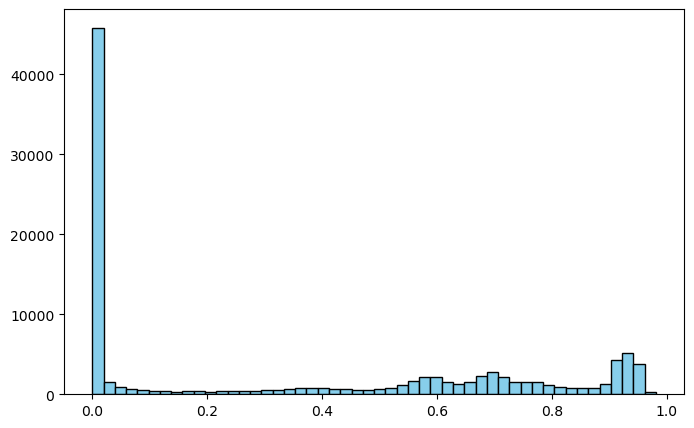

In [48]:
plt.figure(figsize=(8, 5))
plt.hist(oof_prob_spend, bins=50, color='skyblue', edgecolor='black')
plt.show()

In [49]:
from scipy.stats import spearmanr
from scipy.stats import gaussian_kde
corr, _ = spearmanr(oof_prob_spend, y_original)

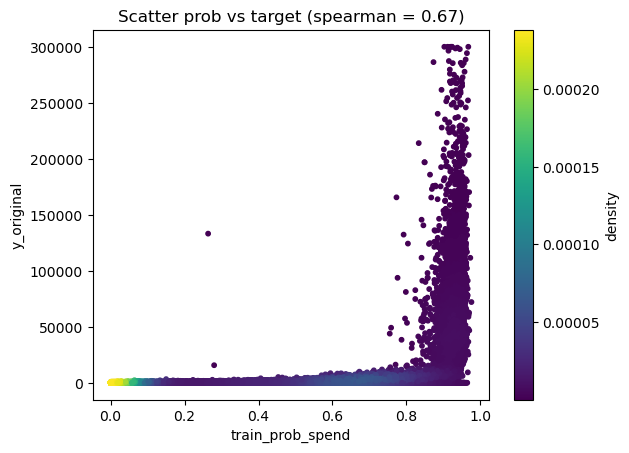

In [50]:
idx = np.random.choice(len(oof_prob_spend), 30000, replace=False)
x_sub = oof_prob_spend[idx]
y_sub = y_original[idx]

z = gaussian_kde(np.vstack([x_sub, y_sub]))(np.vstack([x_sub, y_sub]))

plt.scatter(x_sub, y_sub, c=z, s=10, cmap='viridis')
plt.colorbar(label='density')
plt.xlabel("train_prob_spend")
plt.ylabel("y_original")
plt.title("Scatter prob vs target (spearman = {:.2f})".format(corr))
plt.show()

# Stage 2: Regression

In [51]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold

In [52]:
# Prepare data for Stage 2 (only spenders)
mask_spenders = y_original > 0
X_spenders = X[mask_spenders]
y_amount = y_original[mask_spenders]

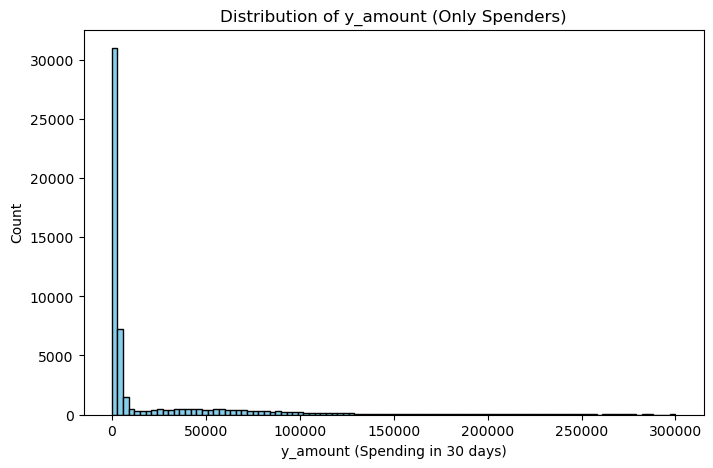

In [57]:
plt.figure(figsize=(8,5))
plt.hist(y_amount, bins=100, color='skyblue', edgecolor='black')
plt.xlabel("y_amount (Spending in 30 days)")
plt.ylabel("Count")
plt.title("Distribution of y_amount (Only Spenders)")
plt.show()

In [ ]:
reg_models = {
    # Linear Models
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),

    'Decision Tree': DecisionTreeRegressor(),

    'XGBoost': XGBRegressor(seed=seed, objective='reg:tweedie'),
    'LightGBM': LGBMRegressor(random_state=seed, verbose=-1, objective='tweedie'),
    'CatBoost': CatBoostRegressor(random_seed=seed, verbose=0, loss_function='Tweedie:variance_power=1.5')
}

In [59]:
# Cross-validation for regression
kf_reg = KFold(n_splits=5, shuffle=True, random_state=seed)

reg_cv_results = {}

for name, model in tqdm(reg_models.items(), desc="Evaluating regression models"):
    # MAE on original scale
    mae_scores = -cross_val_score(
        model, X_spenders, y_amount, 
        cv=kf_reg, scoring='neg_mean_absolute_error'
    )
    
    # Calculate Normalized MAE from MAE
    mean_y = y_amount.mean()
    nmae_scores = 1 / (1 + mae_scores / mean_y)
    
    reg_cv_results[name] = {
        'CV_MAE': mae_scores.mean(),
        'CV_MAE_std': mae_scores.std(),
        'CV_NMAE': nmae_scores.mean(),
        'CV_NMAE_std': nmae_scores.std()
    }

# Create DataFrame
reg_cv_df = pd.DataFrame.from_dict(reg_cv_results, orient='index')
reg_cv_df = reg_cv_df.sort_values(by='CV_NMAE', ascending=False)  # Higher is better

print("\n" + "=" * 70)
print("REGRESSION MODEL SELECTION (Normalized MAE)")
print("=" * 70)
print(reg_cv_df.to_string())

# Best regression model
best_reg_name = reg_cv_df.index[0]
print(f"\n{'=' * 70}")
print(f"✅ BEST REGRESSION MODEL: {best_reg_name}")
print(f"{'=' * 70}")
print(f"Normalized MAE: {reg_cv_df.loc[best_reg_name, 'CV_NMAE']:.6f} ± {reg_cv_df.loc[best_reg_name, 'CV_NMAE_std']:.6f}")
print(f"MAE:            {reg_cv_df.loc[best_reg_name, 'CV_MAE']:.2f} ± {reg_cv_df.loc[best_reg_name, 'CV_MAE_std']:.2f}")

Evaluating regression models:   0%|          | 0/8 [00:00<?, ?it/s]


REGRESSION MODEL SELECTION (Normalized MAE)
                        CV_MAE  CV_MAE_std   CV_NMAE  CV_NMAE_std
CatBoost           3669.413786   23.748652  0.845104     0.000847
LightGBM           3722.496482   34.382120  0.843215     0.001221
XGBoost            3998.860699   54.308402  0.833516     0.001884
Decision Tree      6204.721413  129.598281  0.763420     0.003790
Lasso              7215.994482   51.926352  0.735059     0.001405
Ridge              7217.831518   51.937764  0.735010     0.001405
Linear Regression  7217.968410   51.943175  0.735006     0.001405
ElasticNet         7289.416737   47.751963  0.733082     0.001284

✅ BEST REGRESSION MODEL: CatBoost
Normalized MAE: 0.845104 ± 0.000847
MAE:            3669.41 ± 23.75


In [60]:
# Stage 2: Train regression model on spenders only
best_reg_name = 'LightGBM'
best_reg_model = LGBMRegressor(random_state=seed, verbose=-1, objective='tweedie')
best_reg_model.fit(X_spenders, y_amount)
print(f"✅ Stage 2 ({best_reg_name}) trained on {len(X_spenders)} spenders")

✅ Stage 2 (LightGBM) trained on 53868 spenders


In [ ]:
def objective_reg(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': seed,
        'verbose': -1
    }
    
    model = LGBMRegressor(**params)
    
    # Use Normalized MAE as the optimization metric
    mae_scores = -cross_val_score(
        model, X_spenders, y_amount,
        cv=kf_reg, scoring='neg_mean_absolute_error', n_jobs=-1
    )
    
    mean_y = y_amount.mean()
    nmae_scores = 1 / (1 + mae_scores / mean_y)
    
    return nmae_scores.mean()

# Create Optuna study for regression
study_reg = optuna.create_study(direction='maximize', study_name='lgbm_regressor')

print("Starting Optuna hyperparameter tuning for LightGBM Regressor...")
print(f"Optimizing on {len(X_spenders)} spenders with {X_spenders.shape[1]} features\n")

study_reg.optimize(objective_reg, n_trials=50, show_progress_bar=True)

print("\n" + "=" * 70)
print("OPTUNA OPTIMIZATION RESULTS - REGRESSOR")
print("=" * 70)
print(f"\n✅ Best Normalized MAE: {study_reg.best_value:.6f}")

Starting Optuna hyperparameter tuning for LightGBM Regressor...
Optimizing on 53868 spenders with 48 features



  0%|          | 0/50 [00:00<?, ?it/s]


OPTUNA OPTIMIZATION RESULTS - REGRESSOR

✅ Best Normalized MAE: 0.832489

📊 Best Parameters:
   n_estimators: 436
   learning_rate: 0.013962996430088245
   num_leaves: 145
   max_depth: 9
   min_child_samples: 28
   subsample: 0.7233901852819065
   colsample_bytree: 0.6125370114256586
   reg_alpha: 0.012262324669558981
   reg_lambda: 9.104538892450858

✅ Updated and trained best_reg_model with optimized parameters


### Analysis

In [61]:
X_spenders = X[mask_spenders]
y_amount = y_original[mask_spenders]

In [62]:
y_amount.min()

0.07

In [63]:
import plotly.express as px

fig = px.histogram(x=y_amount[y_amount < 100])
fig.show()

In [64]:
train_amount_pred = best_reg_model.predict(X_spenders)
train_amount_pred

array([  2186.64929682, 145246.97702228,    482.84040979, ...,
         2065.72267374,    512.88336753,    569.67301169])

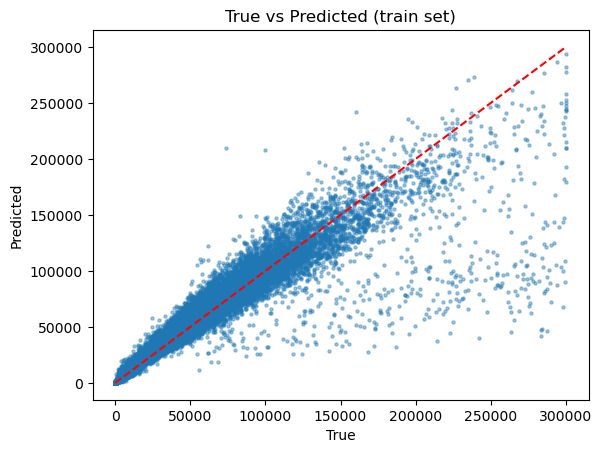

In [65]:
plt.scatter(y_amount, train_amount_pred, s=5, alpha=0.4)
plt.plot([y_amount.min(), y_amount.max()], [y_amount.min(), y_amount.max()], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("True vs Predicted (train set)")
plt.show()

# Combine Model

In [ ]:
class TwoStageModel:
    
    def __init__(self, classifier, regressor, meta_model=None, use_prob_as_feature=False, random_state=42):
        self.classifier = classifier
        self.regressor = regressor
        self.meta_model = meta_model
        self.use_prob_as_feature = use_prob_as_feature
        self.random_state = random_state
        self.is_fitted = False
        
    def fit(self, X, y):
        from sklearn.model_selection import cross_val_predict
        
        y_binary = (y > 0).astype(int)
        
        if self.meta_model is not None:
            prob_oof = cross_val_predict(
                self.classifier, X, y_binary,
                cv=5, method='predict_proba', n_jobs=-1
            )[:, 1]
            
            self.classifier.fit(X, y_binary)
            
            mask_spenders = y > 0
            X_spenders = X[mask_spenders]
            y_spenders = y[mask_spenders]
            
            if len(y_spenders) == 0:
                raise ValueError("No positive samples found in training data")

            amount_oof_spenders = cross_val_predict(
                self.regressor, X_spenders, y_spenders,
                cv=5, n_jobs=-1
            )
            
            # Train regressor on all spenders
            self.regressor.fit(X_spenders, y_spenders)
            
            # Create full amount_oof array
            amount_oof = np.zeros(len(X))
            amount_oof[mask_spenders] = amount_oof_spenders
            
            # For non-spenders, use trained regressor predictions
            if (~mask_spenders).sum() > 0:
                amount_oof[~mask_spenders] = self.regressor.predict(X[~mask_spenders])
            
            meta_features = np.column_stack([prob_oof, amount_oof])
            self.meta_model.fit(meta_features, y)
            
        elif self.use_prob_as_feature:
            prob_oof = cross_val_predict(
                self.classifier, X, y_binary,
                cv=5, method='predict_proba', n_jobs=-1
            )[:, 1]
            
            self.classifier.fit(X, y_binary)
            
            X_with_prob = np.column_stack([X, prob_oof])
            self.regressor.fit(X_with_prob, y)
            
        else:
            self.classifier.fit(X, y_binary)
            
            mask_spenders = y > 0
            X_spenders = X[mask_spenders]
            y_spenders = y[mask_spenders]
            
            if len(y_spenders) == 0:
                raise ValueError("No positive samples found in training data")
            
            self.regressor.fit(X_spenders, y_spenders)
        
        self.is_fitted = True
        return self
    
    def predict(self, X):
        if not self.is_fitted:
            raise ValueError("Model must be fitted before prediction")
        
        prob_spend = self.classifier.predict_proba(X)[:, 1]
        
        if self.meta_model is not None:
            amount_pred = self.regressor.predict(X)
            meta_features = np.column_stack([prob_spend, amount_pred])
            y_pred = self.meta_model.predict(meta_features)
            
        elif self.use_prob_as_feature:
            X_with_prob = np.column_stack([X, prob_spend])
            y_pred = self.regressor.predict(X_with_prob)
            
        else:
            amount_pred = self.regressor.predict(X)
            y_pred = prob_spend * amount_pred
        
        y_pred = np.maximum(y_pred, 0)
        
        return y_pred
    
    def predict_proba(self, X):
        if not self.is_fitted:
            raise ValueError("Model must be fitted before prediction")
        
        return self.classifier.predict_proba(X)[:, 1]
    
    def predict_amount(self, X):
        if not self.is_fitted:
            raise ValueError("Model must be fitted before prediction")
        
        if self.use_prob_as_feature:
            prob_spend = self.classifier.predict_proba(X)[:, 1]
            X_with_prob = np.column_stack([X, prob_spend])
            return self.regressor.predict(X_with_prob)
        else:
            return self.regressor.predict(X)
    
    def score(self, X, y, metric='nmae'):
        y_pred = self.predict(X)
        
        if metric == 'nmae':
            mae = np.mean(np.abs(y - y_pred))
            mean_y = np.mean(y)
            return 1 / (1 + mae / mean_y) if mean_y > 0 else 0
        elif metric == 'mae':
            return np.mean(np.abs(y - y_pred))
        elif metric == 'rmse':
            return np.sqrt(np.mean((y - y_pred) ** 2))
        elif metric == 'r2':
            from sklearn.metrics import r2_score
            return r2_score(y, y_pred)
        else:
            raise ValueError(f"Unknown metric: {metric}")
    
    def get_params(self, deep=True):
        params = {
            'classifier': self.classifier,
            'regressor': self.regressor,
            'meta_model': self.meta_model,
            'use_prob_as_feature': self.use_prob_as_feature,
            'random_state': self.random_state
        }
        
        if deep:
            try:
                clf_params = self.classifier.get_params(deep=True)
                params.update({f'classifier__{k}': v for k, v in clf_params.items()})
            except:
                pass
            
            try:
                reg_params = self.regressor.get_params(deep=True)
                params.update({f'regressor__{k}': v for k, v in reg_params.items()})
            except:
                pass
            
            if self.meta_model is not None:
                try:
                    meta_params = self.meta_model.get_params(deep=True)
                    params.update({f'meta_model__{k}': v for k, v in meta_params.items()})
                except:
                    pass
        
        return params
    
    def set_params(self, **params):
        classifier_params = {}
        regressor_params = {}
        meta_model_params = {}
        base_params = {}
        
        for key, value in params.items():
            if key.startswith('classifier__'):
                classifier_params[key.replace('classifier__', '')] = value
            elif key.startswith('regressor__'):
                regressor_params[key.replace('regressor__', '')] = value
            elif key.startswith('meta_model__'):
                meta_model_params[key.replace('meta_model__', '')] = value
            else:
                base_params[key] = value
        
        for key, value in base_params.items():
            setattr(self, key, value)
        
        if classifier_params:
            self.classifier.set_params(**classifier_params)
        if regressor_params:
            self.regressor.set_params(**regressor_params)
        if meta_model_params and self.meta_model is not None:
            self.meta_model.set_params(**meta_model_params)
        
        return self

In [67]:
best_reg_model

LGBMRegressor(objective='tweedie', random_state=2025, verbose=-1)

In [72]:
two_stage_model = TwoStageModel(
    classifier=best_clf_model,
    regressor=best_reg_model,
    # use_prob_as_feature=True,
    meta_model=CatBoostRegressor(iterations=300, random_state=seed, verbose=0)
)

In [73]:
# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

from sklearn.metrics import make_scorer

def nmae_score(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    mean_y = np.mean(y_true)
    return 1 / (1 + mae / mean_y) if mean_y > 0 else 0

nmae_scorer = make_scorer(nmae_score, greater_is_better=True)

nmae_scores = cross_val_score(
    two_stage_model, X, y_original,
    cv=kf, scoring=nmae_scorer, n_jobs=-1
)

mae_scores = -cross_val_score(
    two_stage_model, X, y_original,
    cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1
)

# Display results
print("\n" + "=" * 70)
print("TWO-STAGE MODEL - CROSS-VALIDATION RESULTS")
print("=" * 70)
print(f"\n📊 Normalized MAE (Competition Metric):")
print(f"   Mean: {nmae_scores.mean():.6f}")
print(f"   Std:  {nmae_scores.std():.6f}")
print(f"   Folds: {nmae_scores}")

print(f"\n📊 MAE:")
print(f"   Mean: {mae_scores.mean():.2f} THB")
print(f"   Std:  {mae_scores.std():.2f} THB")
print(f"   Folds: {mae_scores}")



TWO-STAGE MODEL - CROSS-VALIDATION RESULTS

📊 Normalized MAE (Competition Metric):
   Mean: 0.770822
   Std:  0.005801
   Folds: [0.78149599 0.76463041 0.77173004 0.7686836  0.7675701 ]

📊 MAE:
   Mean: 3083.60 THB
   Std:  127.06 THB
   Folds: [2966.09664941 3318.26452234 2975.76282337 3069.50968091 3088.37309022]


# Prediction

In [ ]:
# Prepare test features
X_test = test_df[feature_cols]

# Stage 1: Predict probability of spending
test_prob_spend = best_clf_model.predict_proba(X_test)[:, 1]
print(f"Stage 1: Predicted spending probabilities")
print(f"   Mean probability: {test_prob_spend.mean():.4f}")
print(f"   Min: {test_prob_spend.min():.4f}, Max: {test_prob_spend.max():.4f}")

# Stage 2: Predict spending amount (for all samples)
test_amount_pred = best_reg_model.predict(X_test)
print(f"Stage 2: Predicted spending amounts")
print(f"   Mean amount: {test_amount_pred.mean():.2f}")
print(f"   Min: {test_amount_pred.min():.2f}, Max: {test_amount_pred.max():.2f}")

# Combined prediction: probability × amount
test_final_pred = test_prob_spend * test_amount_pred

✅ Stage 1: Predicted spending probabilities
   Mean probability: 0.5199
   Min: 0.1474, Max: 0.9603

✅ Stage 2: Predicted spending amounts
   Mean amount: 11979.97
   Min: -1357.20, Max: 260898.02


In [ ]:
test_final_pred = np.maximum(test_final_pred, 0)

print(f"Two-Stage Combined Predictions:")
print(f"   Mean: {test_final_pred.mean():.2f}")
print(f"   Median: {np.median(test_final_pred):.2f}")
print(f"   Min: {test_final_pred.min():.2f}, Max: {test_final_pred.max():.2f}")
print(f"   Predictions = 0: {(test_final_pred == 0).sum()} ({(test_final_pred == 0).sum()/len(test_final_pred)*100:.2f}%)")



✅ Two-Stage Combined Predictions:
   Mean: 10687.93
   Median: 590.68
   Min: 0.00, Max: 245257.04
   Predictions = 0: 140 (0.54%)


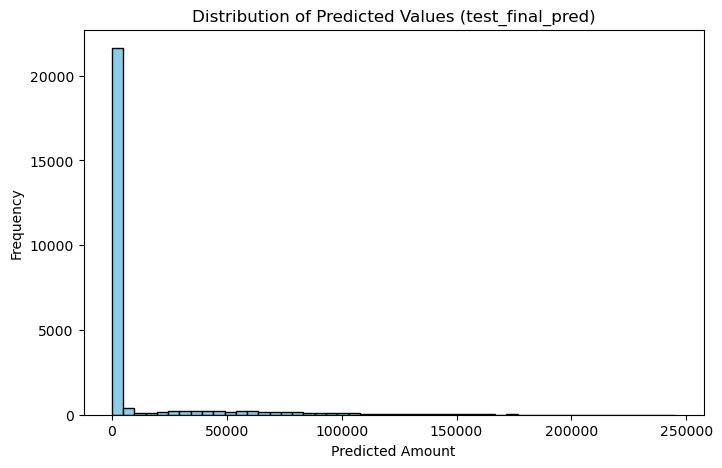

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(test_final_pred, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Predicted Values (test_final_pred)')
plt.xlabel('Predicted Amount')
plt.ylabel('Frequency')
plt.show()

In [26]:
best_csv = pd.read_csv("LGBxCAT-VVS_XGBV1-StackEnsemble_NoHyper-ConvNextxxl_aug-isoXsvm.csv")

In [22]:
best_csv['task3'] = test_final_pred

In [ ]:
best_csv

,id,task1,task2,task3,task4,task5
0,ANS00001,1,2,539.622710,2,1
1,ANS00002,0,1,694.834362,1,1
2,ANS00003,1,3,152193.227116,3,0
3,ANS00004,0,2,125.046653,3,1
4,ANS00005,1,0,307.829604,3,0
...,...,...,...,...,...,...
25884,ANS25885,1,0,74.323294,1,0
25885,ANS25886,1,1,360.738701,0,0
25886,ANS25887,0,1,12169.185615,3,1
25887,ANS25888,0,0,628.770767,4,0


In [24]:
best_csv.to_csv("LGBxCAT-VVS_XGBV1-twoStageSimple-ConvNextxxl_aug-isoXsvm.csv", index=False)

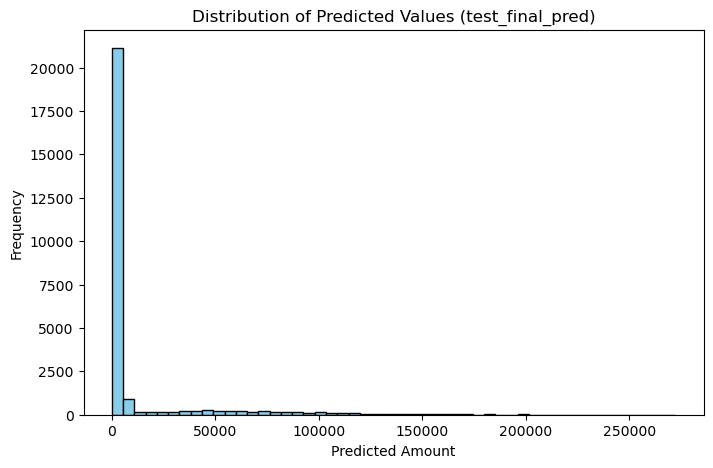

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(best_csv['task3'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Predicted Values (test_final_pred)')
plt.xlabel('Predicted Amount')
plt.ylabel('Frequency')
plt.show()